In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from scipy import signal
from scipy import cluster
import glob
import os
import seaborn as sns;

# Calculation of Integral image

In [ ]:
def g(Im1):
    nx = Im1.shape[0]
    ny = Im1.shape[1]
    
    J = np.zeros((4,nx,ny))
    for x in range(4):
        J[x,:,:] = np.power(Im1,x+1)
    
    I = np.zeros((4,nx,ny))

    for x in range(4):
        I[x,0,0] = J[x,0,0]

        for i in range(nx):
            for j in range(ny):
                # I[i,j] = I[i,j-1] + I[i-1,j] - I[i-1,j-1] + J[i,j]
                a = 0
                b = 0
                c = 0

                if j > 0:
                    a = I[x,i,j-1]
                
                if i > 0:
                    b = I[x,i-1,j]
                
                if i > 0 and j > 0:
                    c = I[x,i-1,j-1]
                
                I[x,i,j] = a + b - c + J[x,i,j]
    
    return I


# Calculation of Kurtosis and noise variance

In [ ]:
def h(kurtosis, var):

    A = np.mean(np.sqrt(kurtosis) ,axis=0) * np.mean(1/(var*var),axis=0)

    B = np.mean( np.sqrt(kurtosis)/var ,axis=0) * np.mean(1/var,axis=0)

    C = np.mean(1/(var*var),axis=0)

    D = np.mean(1/var,axis=0)**2

    kappa = (A - B)/(C - D)

    return kappa



def noise_var(kurtosis,var,kappa):

    A = 1/np.mean(1/var,axis=0)
    B = (1/kappa)*(np.mean(np.sqrt(kurtosis),axis=0))/(np.mean(1/var,axis=0))

    V = A-B
    idx = kappa < np.median(kappa[:])

    V[idx] = A[idx]
    idx = V < 0
    V[idx] = A[idx]

    return V

# Local variance and Kurtosis calculation

In [ ]:
def f(I , window , Im1):
    var = np.zeros(Im1.shape)
    kurtosis = np.zeros(Im1.shape)

    for i in range(Im1.shape[0]):
        for j in range(Im1.shape[1]):
            
            u = [0 for j1 in range(4)]

            z = int(window/2)
            x1 = i - z - 1
            x2 = i + z

            y1 = j - z - 1
            y2 = j + z

            nx = I.shape[1]
            ny = I.shape[2]
            
            for j1 in range(4):
                                # u_m = a -b -c +d
                a = 0
                b = 0
                c = 0
                d = 0

                x1 = max(x1,-1)
                y1 = max(y1,-1)
                x2 = min(x2,nx-1)
                y2 = min(y2,ny-1)


                if(x1 >= 0 and y1 >= 0):
                    d = I[j1,x1,y1]

                if x1 >= 0:
                    b = I[j1,x1,y2]
                
                if y1 >= 0:
                    c = I[j1,x2,y1]
                  
                a = I[j1,x2,y2]
                  
                #print(a,b,c,d)
                u[j1] = (a-b-c+d)/abs((x2-x1)*(y2-y1))

                
            #print(u[0],u[1],u[2],u[3])
            kurtosis[i,j] = (u[3]-4*u[2]*u[0] + 6*u[1]*u[0]*u[0] - 3*u[0]**4)/(u[1]**2 - 2*u[1]*u[0]*u[0] + u[0]**4) - 3
            var[i,j] = u[1] - u[0]**2


    return kurtosis, var

# DCT to MATRIX

In [ ]:
def convert_to_matrix(N):
  [cc, rr] = np.meshgrid(np.arange(0,N),np.arange(0,N))
  c = np.sqrt(2/N)*np.cos(np.pi *(2*cc + 1)*rr / (2*N))
  c[0,:] = c[0,:]/np.sqrt(2)
  order = np.arange(N**2)
  order = order.reshape((N,N)).transpose()
 # print(c[0,:].transpose().shape)

  output = np.zeros((N*N, N, N))
  for i in range(N):
    for j in range(N):
      output[order[i][j],:,:] = np.matmul(c[i,:].reshape(N,1),c[j,:].reshape(1,N))

  return output




# Directory for testing

In [ ]:
window = 7
K = 8*8

for iii in glob.glob("images/*.bmp"):
  Im1 = plt.imread(iii)

  Im = np.zeros((K,Im1.shape[0],Im1.shape[1]))
  Im2 = convert_to_matrix(8)

  for k in range(K):
    T = signal.convolve2d(Im1,Im2[k,:,:],mode='same')

    Im[k,:,:] = T
  nx = Im.shape[1]
  ny = Im.shape[2]

  I = np.zeros((K,4,nx,ny))
  Var = np.zeros((K,nx,ny))
  kurtosis = np.zeros((K,nx,ny))

  for i in range(K):
    I[i,:,:] = g(Im[i,:,:])
    kurtosis[i,:,:],Var[i,:,:] = f( I[i,:,:], window, Im[i,:,:] )
  kurtosis[kurtosis<0] = 0
  kappa = h(kurtosis,Var)
  noise_variance = noise_var(kurtosis,Var,kappa)
  noise_variance=np.log(noise_variance)
  plt.imshow(noise_variance,cmap='gray')
  plt.imsave('good_spliced_variances/'+os.path.basename(iii)[:-3]+'jpg',noise_variance,cmap='gray')
  print("done with "+os.path.basename(iii))
  

# Test image

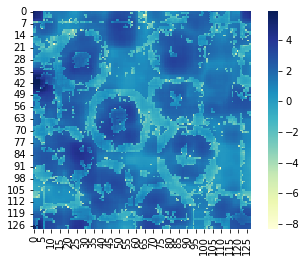

In [ ]:
Im1 = plt.imread('/content/AU_T_082.bmp')
Im = np.zeros((K,Im1.shape[0],Im1.shape[1]))
Im2 = convert_to_matrix(8)
for k in range(K):
  T = signal.convolve2d(Im1,Im2[k,:,:],mode='same')
  Im[k,:,:] = T
nx = Im.shape[1]
ny = Im.shape[2]
I= np.zeros((K,4,nx,ny))
Var = np.zeros((K,nx,ny))
kurtosis = np.zeros((K,nx,ny))
for i in range(K):
  I[i,:,:] = g(Im[i,:,:])
  kurtosis[i,:,:],Var[i,:,:] = f( I[i,:,:], window, Im[i,:,:] )
kurtosis[kurtosis<0] = 0
kappa = h(kurtosis,Var)
noise_variance = noise_var(kurtosis,Var,kappa)
noise_variance=np.log(noise_variance)
plt.imshow(noise_variance,cmap='gray')
# heat map
ax = sns.heatmap(noise_variance,cmap='YlGnBu')

# K means

In [ ]:
X1 = noise_variance.reshape((nx*ny,1))
Y1 = cluster.vq.kmeans2(X1,2)


plt.imshow(Y1[1].reshape((nx,ny)))